<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#14-6.-프로젝트-:-폐렴-진단기-성능개선" data-toc-modified-id="14-6.-프로젝트-:-폐렴-진단기-성능개선-1">14-6. 프로젝트 : 폐렴 진단기 성능개선</a></span><ul class="toc-item"><li><span><a href="#Step-1.-실험환경-Set-up" data-toc-modified-id="Step-1.-실험환경-Set-up-1.1">Step 1. 실험환경 Set-up</a></span><ul class="toc-item"><li><span><a href="#분산처리를-위한-인스턴스" data-toc-modified-id="분산처리를-위한-인스턴스-1.1.1">분산처리를 위한 인스턴스</a></span></li></ul></li><li><span><a href="#Step-2.-데이터-준비하기" data-toc-modified-id="Step-2.-데이터-준비하기-1.2">Step 2. 데이터 준비하기</a></span><ul class="toc-item"><li><span><a href="#Keras의-ImageDataGenerator()를-사용해-augmentation을-적용하며-데이터-로드" data-toc-modified-id="Keras의-ImageDataGenerator()를-사용해-augmentation을-적용하며-데이터-로드-1.2.1">Keras의 ImageDataGenerator()를 사용해 augmentation을 적용하며 데이터 로드</a></span></li><li><span><a href="#train-데이터-안에-정상-이미지-수와-폐렴-이미지-수를-확인" data-toc-modified-id="train-데이터-안에-정상-이미지-수와-폐렴-이미지-수를-확인-1.2.2">train 데이터 안에 정상 이미지 수와 폐렴 이미지 수를 확인</a></span></li></ul></li><li><span><a href="#Step-3.-데이터-시각화" data-toc-modified-id="Step-3.-데이터-시각화-1.3">Step 3. 데이터 시각화</a></span></li><li><span><a href="#Step-4.-CNN-모델링" data-toc-modified-id="Step-4.-CNN-모델링-1.4">Step 4. CNN 모델링</a></span></li><li><span><a href="#Step-5.-데이터-imbalance-처리" data-toc-modified-id="Step-5.-데이터-imbalance-처리-1.5">Step 5. 데이터 imbalance 처리</a></span></li><li><span><a href="#Step-6.-모델-훈련" data-toc-modified-id="Step-6.-모델-훈련-1.6">Step 6. 모델 훈련</a></span></li><li><span><a href="#Step-7.-결과-확인과-시각화" data-toc-modified-id="Step-7.-결과-확인과-시각화-1.7">Step 7. 결과 확인과 시각화</a></span></li><li><span><a href="#루브릭" data-toc-modified-id="루브릭-1.8">루브릭</a></span></li><li><span><a href="#참고" data-toc-modified-id="참고-1.9">참고</a></span></li><li><span><a href="#후기" data-toc-modified-id="후기-1.10">후기</a></span></li></ul></li></ul></div>

# 14-6. 프로젝트 : 폐렴 진단기 성능개선

좀전까지 우리는 대략 80% 정도의 정확도를 가진 X-RAY 사진 판독 폐렴 진단기를 만들어 보았습니다.

하지만 숙련된 의사분들은 90% 이상에 도달한다고 하니, 좀더 분발해야겠죠?

그렇다면 우리는 좀전까지의 실습 과정을 되짚어보면서, 어떤 점을 좀더 개선해볼 수 있을지 따져 보고 스스로 개선해 가면서 좀더 성능을 향상시켜 보려고 합니다.

## Step 1. 실험환경 Set-up

거의 바꿔볼 수 있을게 없을 것 같지만, Batch size, Epoch 등을 변경해볼 수 있을 것입니다.

In [40]:
import re  # 정규표현식 관련된 작업에 필요한 패키지
import os  # I/O 관련된 작업에 필요한 패키지
import pandas as pd  # 데이터 전처리 관련된 작업에 필요한 패키지
import numpy as np  # 데이터 array 작업에 필요한 패키지
import tensorflow as tf  # 딥러닝 관련된 작업에 필요한 패키지
import matplotlib.pyplot as plt  # 데이터 시각화에 관련된 작업에 필요한 패키지
import seaborn as sns
import collections
from sklearn.model_selection import train_test_split  # 데이터 전처리에 필요한 패키지
from sklearn.metrics import classification_report, confusion_matrix
from keras_preprocessing.image import ImageDataGenerator

### 분산처리를 위한 인스턴스

하지만 GPU가 돌아가지 않았다는 함정..

In [2]:
strategy = tf.distribute.MirroredStrategy()
print(f'Number of replicas: {strategy.num_replicas_in_sync}')
print(tf.__version__)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of replicas: 2
2.4.1


In [3]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [150, 150]

# 변경해볼 수 있는 변수
BATCH_SIZE = 32*strategy.num_replicas_in_sync  # BATCH_SIZE: 32~256 (2^n)
EPOCHS = 100  # EPOCHS: early stopping

print(ROOT_PATH)

/home/mochafreddo/aiffel


## Step 2. 데이터 준비하기

### Keras의 ImageDataGenerator()를 사용해 augmentation을 적용하며 데이터 로드

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    # randomly rotate images in the range (degrees, 0 to 180)
    rotation_range=30,
    # randomly shift images horizontally (fraction of total width)
    width_shift_range=0.1,
    # randomly shift images vertically (fraction of total height)
    height_shift_range=0.1,
    zoom_range=0.2,  # Randomly zoom image
    horizontal_flip=True,  # randomly flip images
    validation_split=0.2,
    dtype='float32'
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    dtype='float32'
)

In [5]:
train_ds = train_datagen.flow_from_directory(str(
    ROOT_PATH + '/chest_xray/train'), target_size=IMAGE_SIZE, class_mode='binary', batch_size=BATCH_SIZE, subset='training')
val_ds = train_datagen.flow_from_directory(str(
    ROOT_PATH + '/chest_xray/train'), target_size=IMAGE_SIZE, class_mode='binary', batch_size=BATCH_SIZE, subset='validation')
test_ds = test_datagen.flow_from_directory(str(
    ROOT_PATH + '/chest_xray/test'), target_size=IMAGE_SIZE, class_mode='binary', batch_size=BATCH_SIZE, shuffle=False)

train_ds.class_indices

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


{'NORMAL': 0, 'PNEUMONIA': 1}

validation 폴더의 이미지가 너무 적어 train 폴더 내의 이미지로 validation set을 구성했습니다.

In [6]:
TRAIN_IMG_COUNT = train_ds.n
VAL_IMG_COUNT = val_ds.n
COUNT_NORMAL = collections.Counter(train_ds.labels)[0]
COUNT_PNEUMONIA = collections.Counter(train_ds.labels)[1]

### train 데이터 안에 정상 이미지 수와 폐렴 이미지 수를 확인

<AxesSubplot:xlabel='class', ylabel='count'>

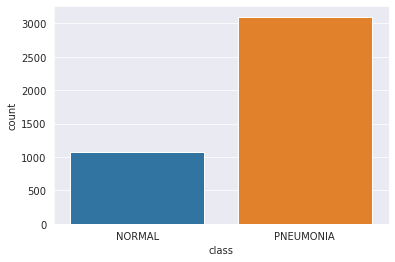

In [7]:
df = pd.DataFrame(train_ds.labels, columns=['class'])
df[df['class'] == 0] = 'NORMAL'
df[df['class'] == 1] = 'PNEUMONIA'
sns.set_style('darkgrid')
sns.countplot(data=df, x='class')

결과를 보면 정상보다 폐렴 이미지 수가 3배 더 많이 있습니다.  
우리가 사용할 CNN 모델의 경우 데이터가 클래스별 balance가 좋을 수록 **<u>training</u>** 을 잘 합니다.  
데이터가 클래스 불균형(imbalance)한 것은 차후에 조정할 예정입니다.  
<u>test와 val 데이터셋은 평가하기 위해서 사용되기 때문에 학습과 관련이 없으므로 imbalance한 데이터 셋이어도 문제 없습니다.</u>

## Step 3. 데이터 시각화

augmentation이 적용된 이미지를 확인할 수 있습니다.

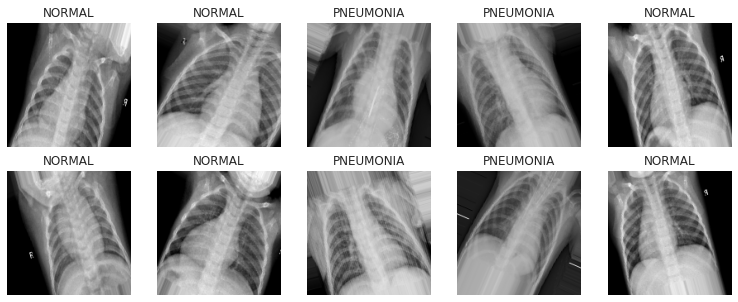

In [8]:
image_batch, label_batch = next(iter(train_ds))
plt.figure(figsize=(13, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(image_batch[i])
    if label_batch[i]:
        plt.title("PNEUMONIA")
    else:
        plt.title("NORMAL")
    plt.axis("off")

## Step 4. CNN 모델링

의료영상 판독을 위해 실습에서 구현했던 model에서 다양한 것들을 바꾸어 가며 실험해볼 수 있습니다. Convolution filter, 채널 개수, activation, 모델구조 등을 다양하게 바꾸어볼 수 있습니다.

그리고, 우리는 BatchNormalization과 Dropout을 한 모델 안에서 동시에 사용하는 특이한 구성을 실습했습니다.  
이것은 일반적으로 잘 사용되는 형태는 아닙니다. 하지만 이미지 사이즈가 크고 데이터가 부족한 의료영상에서는 실용적으로 간혹 좋은 성능을 보이기도 합니다. 만약 이 구성을 변경해 보면 어떤 효과가 발생하는지도 실험해 봅시다. BatchNormalization을 쓰거나 혹은 쓰지 않거나, Dropout을 쓰거나 혹은 쓰지 않거나 할 수 있습니다. 또, Dropout 비율을 변경해볼 수도 있습니다.

In [9]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),

        tf.keras.layers.Conv2D(32, (3, 3), strides=1,
                               padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D((2, 2), strides=2, padding='same'),

        tf.keras.layers.Conv2D(64, (3, 3), strides=1,
                               padding='same', activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D((2, 2), strides=2, padding='same'),

        tf.keras.layers.Conv2D(64, (3, 3), strides=1,
                               padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D((2, 2), strides=2, padding='same'),

        tf.keras.layers.Conv2D(128, (3, 3), strides=1,
                               padding='same', activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D((2, 2), strides=2, padding='same'),

        tf.keras.layers.Conv2D(256, (3, 3), strides=1,
                               padding='same', activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D((2, 2), strides=2, padding='same'),

        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(units=128, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(units=1, activation='sigmoid')
    ])

    return model

## Step 5. 데이터 imbalance 처리

실습코드에서 데이터의 imbalance 문제에 대처하기 위해 데이터 비율로 나누어진 `class_weight`를 설정해 주었습니다. 만약 이러한 처리를 생략한다면 어떻게 될까요? 또 recall을 강조하기 위해 폐렴데이터를 잘 맞추는 것을 더 강화하는 효과를 만들어낼 수는 없을까요?

In [10]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.94
Weight for class 1: 0.67


## Step 6. 모델 훈련

loss 함수를 변경하기는 어렵겠지만, optimizer나 learning rate 등의 변화를 고려해볼 수 있을 것입니다.

In [11]:
with strategy.scope():
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(
        optimizer='rmsprop',  # optimizer를 adam에서 rmsporp으로 변경
        loss='binary_crossentropy',
        metrics=METRICS
    )

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [12]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    './chest_xray/xray_model.h5', save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True)

learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', patience=2, verbose=1, factor=0.3, min_lr=0.000001)

In [13]:
history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT//BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT//BATCH_SIZE,
    class_weight=class_weight,
    callbacks=[checkpoint_cb, early_stopping_cb, learning_rate_reduction],
    workers=48,
    use_multiprocessing=True
)

Epoch 1/100
INFO:tensorflow:batch_all_reduce: 24 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 24 all-reduces with algorithm = nccl, num_packs = 1
65/65 [==============================] - 29s 285ms/step - loss: 1.7275 - accuracy: 0.7411 - precision: 0.8995 - recall: 0.7294 - val_loss: 8.6904 - val_accuracy: 0.7432 - val_precision: 0.7432 - val_recall: 1.0000
Epoch 2/100
65/65 [==============================] - 21s 273ms/step - loss: 0.3172 - accuracy: 0.8691 - precision: 0.9678 - recall: 0.8544 - val_loss: 11.3517 - val_accuracy: 0.7432 - val_precision: 0.7432 - val_recall: 1.0000
Epoch 3/100
65/65 [==============================] - 21s 280ms/step - loss: 0.2980 - accuracy: 0.8778 - precision: 0.9686 - recall: 0.8615 - val_loss: 12.4518 - val_accuracy: 0.7461 - val_precision: 0.7461 - val_recall: 1.0000
Epoch 4/100
65/65 [==============================] - 16s 202ms/step - loss: 0.2863 - accuracy: 0.8813 - precision: 0.9577 - recall: 0.8774 - val_los

65/65 [==============================] - 23s 296ms/step - loss: 0.1711 - accuracy: 0.9580 - precision: 0.9854 - recall: 0.9566 - val_loss: 1.5785 - val_accuracy: 0.7959 - val_precision: 0.7849 - val_recall: 0.9987
Epoch 10/100
65/65 [==============================] - 23s 293ms/step - loss: 0.1130 - accuracy: 0.9582 - precision: 0.9838 - recall: 0.9595 - val_loss: 1.6660 - val_accuracy: 0.8027 - val_precision: 0.7900 - val_recall: 0.9987
Epoch 11/100
65/65 [==============================] - 22s 290ms/step - loss: 0.1292 - accuracy: 0.9480 - precision: 0.9845 - recall: 0.9454 - val_loss: 0.1837 - val_accuracy: 0.9326 - val_precision: 0.9314 - val_recall: 0.9816
Epoch 12/100
65/65 [==============================] - 23s 292ms/step - loss: 0.1217 - accuracy: 0.9640 - precision: 0.9877 - recall: 0.9632 - val_loss: 0.7347 - val_accuracy: 0.7793 - val_precision: 1.0000 - val_recall: 0.7026
Epoch 13/100
65/65 [==============================] - 22s 278ms/step - loss: 0.1161 - accuracy: 0.9592 - 

Epoch 19/100
65/65 [==============================] - 23s 299ms/step - loss: 0.1116 - accuracy: 0.9650 - precision: 0.9876 - recall: 0.9648 - val_loss: 0.0889 - val_accuracy: 0.9639 - val_precision: 0.9714 - val_recall: 0.9803

Epoch 00019: ReduceLROnPlateau reducing learning rate to 8.100000013655517e-06.
Epoch 20/100
65/65 [==============================] - 22s 292ms/step - loss: 0.1006 - accuracy: 0.9634 - precision: 0.9886 - recall: 0.9618 - val_loss: 0.1024 - val_accuracy: 0.9600 - val_precision: 0.9853 - val_recall: 0.9608
Epoch 21/100
65/65 [==============================] - 19s 226ms/step - loss: 0.1057 - accuracy: 0.9673 - precision: 0.9880 - recall: 0.9676 - val_loss: 0.1632 - val_accuracy: 0.9346 - val_precision: 0.9957 - val_recall: 0.9157

Epoch 00021: ReduceLROnPlateau reducing learning rate to 2.429999949526973e-06.
Epoch 22/100
65/65 [==============================] - 24s 303ms/step - loss: 0.0889 - accuracy: 0.9661 - precision: 0.9904 - recall: 0.9636 - val_loss: 0.109

65/65 [==============================] - 18s 215ms/step - loss: 0.1085 - accuracy: 0.9622 - precision: 0.9882 - recall: 0.9606 - val_loss: 0.1420 - val_accuracy: 0.9463 - val_precision: 1.0000 - val_recall: 0.9274
Epoch 29/100
65/65 [==============================] - 24s 307ms/step - loss: 0.1153 - accuracy: 0.9660 - precision: 0.9841 - recall: 0.9699 - val_loss: 0.1352 - val_accuracy: 0.9385 - val_precision: 0.9915 - val_recall: 0.9249


Process Keras_worker_ForkPoolWorker-4274:
Process Keras_worker_ForkPoolWorker-4300:
Process Keras_worker_ForkPoolWorker-4315:
Process Keras_worker_ForkPoolWorker-4279:
Process Keras_worker_ForkPoolWorker-4291:
Process Keras_worker_ForkPoolWorker-4277:
Process Keras_worker_ForkPoolWorker-4301:
Process Keras_worker_ForkPoolWorker-4289:
Traceback (most recent call last):
Process Keras_worker_ForkPoolWorker-4308:
Process Keras_worker_ForkPoolWorker-4276:
Traceback (most recent call last):
Process Keras_worker_ForkPoolWorker-4286:
Process Keras_worker_ForkPoolWorker-4307:
Process Keras_worker_ForkPoolWorker-4280:
Process Keras_worker_ForkPoolWorker-4303:
Traceback (most recent call last):
Process Keras_worker_ForkPoolWorker-4319:
Process Keras_worker_ForkPoolWorker-4314:
Traceback (most recent call last):
  File "/home/mochafreddo/anaconda3/envs/aiffel/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Process Keras_worker_ForkPoolWorker-4295:
Traceback (most 

  File "/home/mochafreddo/anaconda3/envs/aiffel/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/mochafreddo/anaconda3/envs/aiffel/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/mochafreddo/anaconda3/envs/aiffel/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/mochafreddo/anaconda3/envs/aiffel/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/mochafreddo/anaconda3/envs/aiffel/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/mochafreddo/anaconda3/envs/aiffel/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/mochafreddo/anaconda3/envs/aiffel/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  

  File "/home/mochafreddo/anaconda3/envs/aiffel/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/mochafreddo/anaconda3/envs/aiffel/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/mochafreddo/anaconda3/envs/aiffel/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/mochafreddo/anaconda3/envs/aiffel/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/mochafreddo/anaconda3/envs/aiffel/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/mochafreddo/anaconda3/envs/aiffel/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/mochafreddo/anaconda3/envs/aiffel/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/

  File "/home/mochafreddo/anaconda3/envs/aiffel/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/mochafreddo/anaconda3/envs/aiffel/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/mochafreddo/anaconda3/envs/aiffel/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/mochafreddo/anaconda3/envs/aiffel/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/mochafreddo/anaconda3/envs/aiffel/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/mochafreddo/anaconda3/envs/aiffel/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/mochafreddo/anaconda3/envs/aiffel/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/mochafreddo/anaconda3/en

  File "/home/mochafreddo/anaconda3/envs/aiffel/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/mochafreddo/anaconda3/envs/aiffel/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/mochafreddo/anaconda3/envs/aiffel/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/mochafreddo/anaconda3/envs/aiffel/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/mochafreddo/anaconda3/envs/aiffel/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/mochafreddo/anaconda3/envs/aiffel/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/mochafreddo/anaconda3/envs/aiffel/lib/python3.7/multiprocessing/synchroni

그냥 무식하게 CPU 혹사 시켜서 학습을 진행했다.

## Step 7. 결과 확인과 시각화

테스트데이터로 훈련된 모델을 평가해 봅시다. 우선은 accuracy를 고려해야겠지만 의료영상 모델의 특성상 recall도 중요합니다. 훈련과정의 history 그래프를 시각화해 보고, 학습 진행양상을 면밀히 분석해 보는 것도 잊지 않도록 합시다.

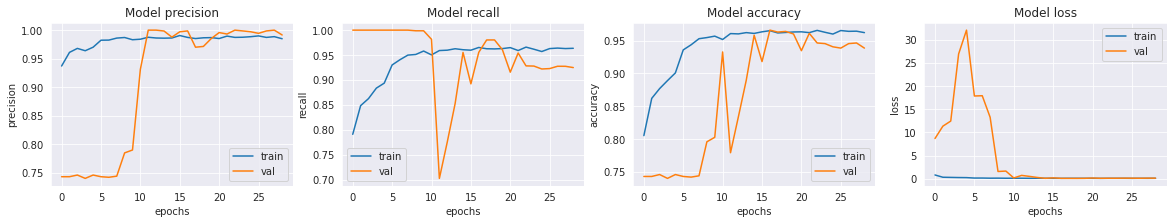

In [14]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [15]:
loss, acc, prec, rec = model.evaluate(test_ds)

10/10 [==============================] - 5s 403ms/step - loss: 0.4093 - accuracy: 0.8894 - precision: 0.8849 - recall: 0.9462


## 루브릭

아래의 기준을 바탕으로 프로젝트를 평가합니다.

|평가문항|상세기준|
|:---|:---|
|1. 의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다.|모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.|
|2. 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다.|regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었다.|
|3. 실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다.|Accuracy 기준 85%에 도달하였다.|

## 참고

- [TensorFlow Pneumonia Classification on X-rays | Kaggle](https://www.kaggle.com/amyjang/tensorflow-pneumonia-classification-on-x-rays)
- [Pneumonia Detection using CNN(92.6% Accuracy) | Kaggle](https://www.kaggle.com/madz2000/pneumonia-detection-using-cnn-92-6-accuracy#Analysis-after-Model-Training)
- [Keras - CNN ImageDataGenerator 활용하기 :: Deep Play](https://3months.tistory.com/199)
- [[고군분투 머신러닝] Data Augmentation,ImageDataGenerator 사용법 : 네이버 블로그](https://m.blog.naver.com/PostView.nhn?blogId=isu112600&logNo=221582003889&proxyReferer=https:%2F%2Fwww.google.com%2F)

## 후기

- CPU한테 미안해서 학습을 더 해볼 엄두가 나지 않습니다.
- 검색을 해봐도 커뮤니티에 질문을 해봐도 ImageDataGenerator()를 사용해도 GPU 사용에 문제가 없다는데 왜 이 코드만 안 돌아가는지 모르겠습니다. 혹시 몰라서 예제 코드도 돌려봤는데 GPU가 잘 돌아갑니다. 원인을 찾아보고 싶은데 시간이 없어 일단 넘어갔습니다.
- Accurcy는 88%, Recall은 94% 가 나오긴 했습니다.
- 여러 가지 상황들을 만들며 비교분석해보고 싶은데 시간이 부족해 아쉽습니다.
- 이번에는 다른 사람들의 코드를 참고하며 공부하는 식으로 진행했습니다. 덕분에 여러 가지 배울 수 있었습니다.